In [1]:
import torch
from rim import RIM, Hourglass
import matplotlib.pyplot as plt
from torch.func import vmap
from tqdm import tqdm
from score_models import ScoreModel, NCSNpp
import pickle
import numpy as np
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

matmul = vmap(torch.matmul)

# Load data and check everything is fine

In [7]:
responses_data = pickle.load(open('../data/RIM_clusters/rmfs_original.pkl', 'rb'))
# Path to true spectra (x)
true_spectra_data = pickle.load(open('../data/RIM_clusters/true_original.pkl', 'rb'))
min_ = 35
max_ = 175

# Read in A, and x
X = np.stack([data[1][1][min_:max_] for data in true_spectra_data.items()])
A_dataset = np.stack([responses_data[val][min_:max_,min_:max_].T for val in responses_data]) # Need to use the tranpose of the dataset, saved in wrong order

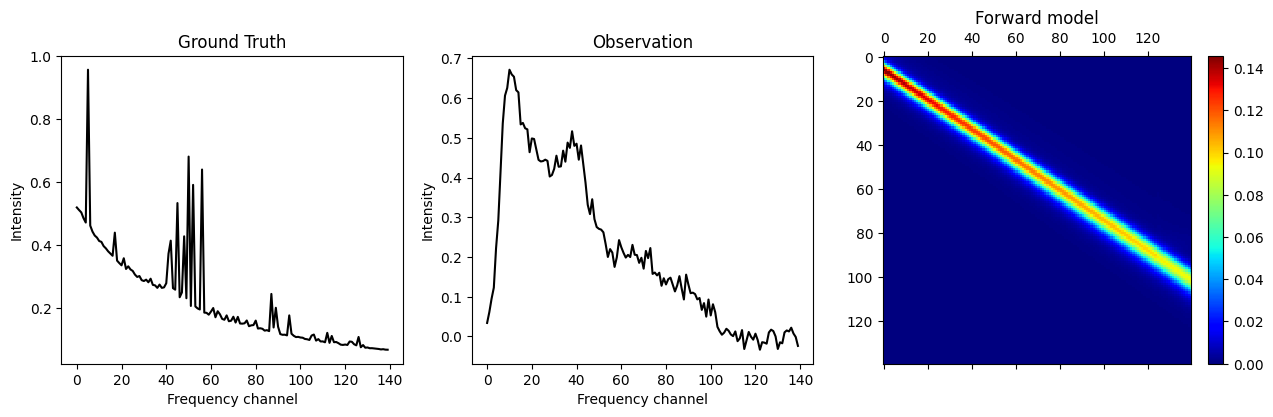

In [8]:
# sample a response matrix
k = np.random.randint(len(A_dataset))
A = A_dataset[k]

# Pick a ground truth
k = np.random.randint(len(X))
x_true = X[k]

# Pick an SNR
snr = 50
sigma_n = x_true.max() / snr

# Make the observation
y = A @ x_true
y += np.random.randn(*y.shape) * sigma_n

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Ground Truth")
ax1.plot(x_true, "-k")
ax1.set_xlabel("Frequency channel")
ax1.set_ylabel("Intensity")

ax2.set_title("Observation")
ax2.plot(y, "-k")
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")

ax3.set_title("Forward model")
im = ax3.matshow(A, cmap="jet")
plt.colorbar(im, ax=ax3, fraction=0.046)

# Make a train/test split

In [29]:
seed = 42
np.random.seed(seed)
split = 0.9
k_train = np.random.choice(len(X), size=int(split * len(X)), replace=False)
print(len(X))
print(len(k_train))
X_train = X[k_train]
k_test = list(set(list(range(len(X)))).difference(set(k_train)))
print(len(k_test))
X_test = X[k_test]
np.save("../data/spectra_train.npy", X_train)
np.save("../data/spectra_test.npy", X_train)

k_train = np.random.choice(len(A_dataset), size=int(split * len(A_dataset)), replace=False)
A_train = A_dataset[k_train]
k_test = list(set(list(range(len(A_dataset)))).difference(set(k_train)))
A_test = A_dataset[k_test]
np.save("../data/A_train.npy", A_train)
np.save("../data/A_test.npy", A_test)

10000
9000
1000


# Training the RIM with a diffusion model

Epoch 500 | Cost: 1.1e+01 |: 100%|██████████| 500/500 [11:35<00:00,  1.39s/it]

Finished training after 0.193 hours.


Text(0.5, 0, 'Epoch')

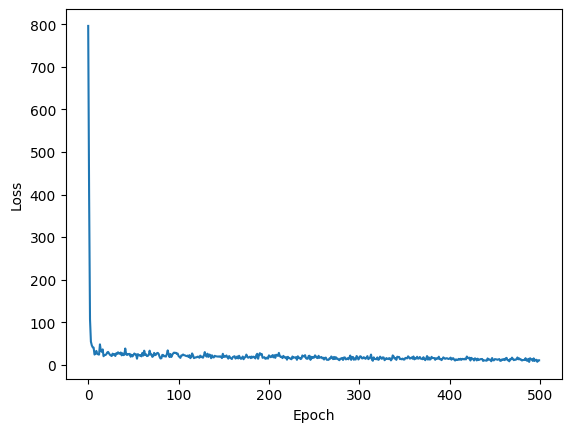

In [9]:
prior_path = "../models/score_xray_clusters_20230731_2"
prior = ScoreModel(checkpoints_directory=prior_path, dimensions=1)

prior_T = 0.1
temperature = lambda batch_size: torch.ones(batch_size).to(DEVICE) * prior_T
def prior_score(x):
    B, *D = x.shape
    return prior.score(temperature(B), x)

snr_max = 100
snr_min = 5
m = A_dataset[0].shape[0] # model space
n = A_dataset[0].shape[1] # observation space

@vmap
def likelihood_score_fn(x, y, A, sigma_n): # make sure to respect this signature (x, y, *args)
    y_pred = A @ x.squeeze() # remove channel dimension of x.
    score = - (y - y_pred) @ (-A) / sigma_n**2
    return score.unsqueeze(0) # give score back its channel dimensions

def score_fn(x, y, A, sigma_n):
    return likelihood_score_fn(x, y, A, sigma_n) + prior_score(x)

# Make a dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        k1 = np.random.randint(len(X_train))
        k2 = np.random.randint(len(A_train))
        x = torch.tensor(X[k1]).float().to(DEVICE)
        A = torch.tensor(A_dataset[k2]).float().to(DEVICE)
        y = A @ x # noiseless observation
        # Uniform distribution in SNR
        snr = torch.rand([]).to(DEVICE) * (snr_max - snr_min) + snr_min
        sigma_n = y.max() / snr
        z = torch.randn([n]).to(DEVICE) * sigma_n
        y = y + z # noisy observation
        # for dataset, it's the traditional ml signature (inputs, labels, *args)
        return y, x.view(1, -1), A, sigma_n # add channel dimension to x

dataset = Dataset(len(X_train))
checkpoints_directory = "rim_xray_clusters_20230731_with_prior"
# nf is the number of filte rin the first layer, ch_mult is how we multiply this number in each level
# length of ch_mult is the number of downsampling
model = Hourglass(channels=1, nf=64, ch_mult=(2, 2)).to(DEVICE)
rim = RIM(dimensions=[m], model=model, score_fn=score_fn, device=DEVICE)

losses = rim.fit(
    dataset, 
    checkpoints_directory=checkpoints_directory, 
    epochs=500,
    batch_size=32,
    learning_rate=1e-4,
    checkpoints=1,
    models_to_keep=3,
    clip=1
)
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Testing predictions

Text(0, 0.5, 'Intensity')

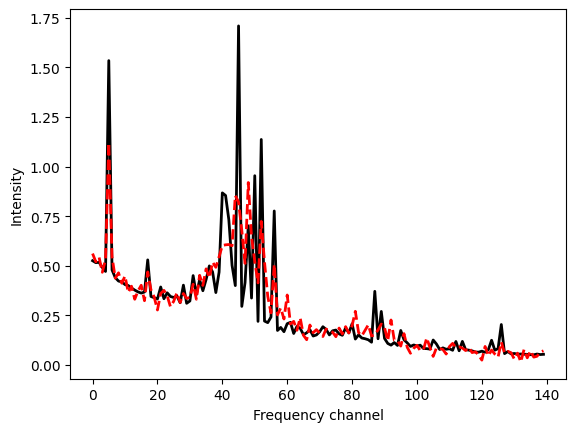

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
y, x, A, sigma_n = next(iter(dataloader))
rim.eval()
with torch.no_grad():
    x_pred = rim.predict(y, A, sigma_n)

plt.plot(x.squeeze().cpu(), "-k", lw=2, label="Ground Truth")
plt.plot(x_pred.squeeze().cpu(), "--r", lw=2, label="RIM")
plt.xlabel("Frequency channel")
plt.ylabel("Intensity")

# Check rim series

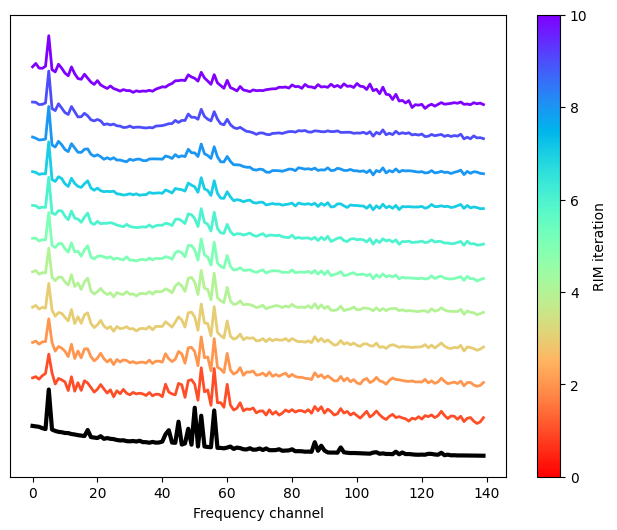

In [15]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
y, x, A, sigma_n = next(iter(dataloader))
rim.eval()
with torch.no_grad():
    x_series = rim(y, A, sigma_n)
    
plt.figure(figsize=(8, 6))
cmap = plt.cm.rainbow_r
norm = plt.cm.colors.Normalize(0, rim.T)
plt.plot(x.squeeze().cpu()/x.cpu().max(), "-k", lw=3, label="Ground Truth")
for t, x in enumerate(x_series):
    plt.plot(x_series[t].squeeze().cpu()/x_series[t].cpu().max() + (rim.T - t)/2, "-", color=cmap(norm(rim.T - t)), lw=2, label="RIM")
plt.xlabel("Frequency channel")
# plt.ylabel("RIM iteration")
ax = plt.gca()
ax.get_yaxis().set_visible(False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("RIM iteration")

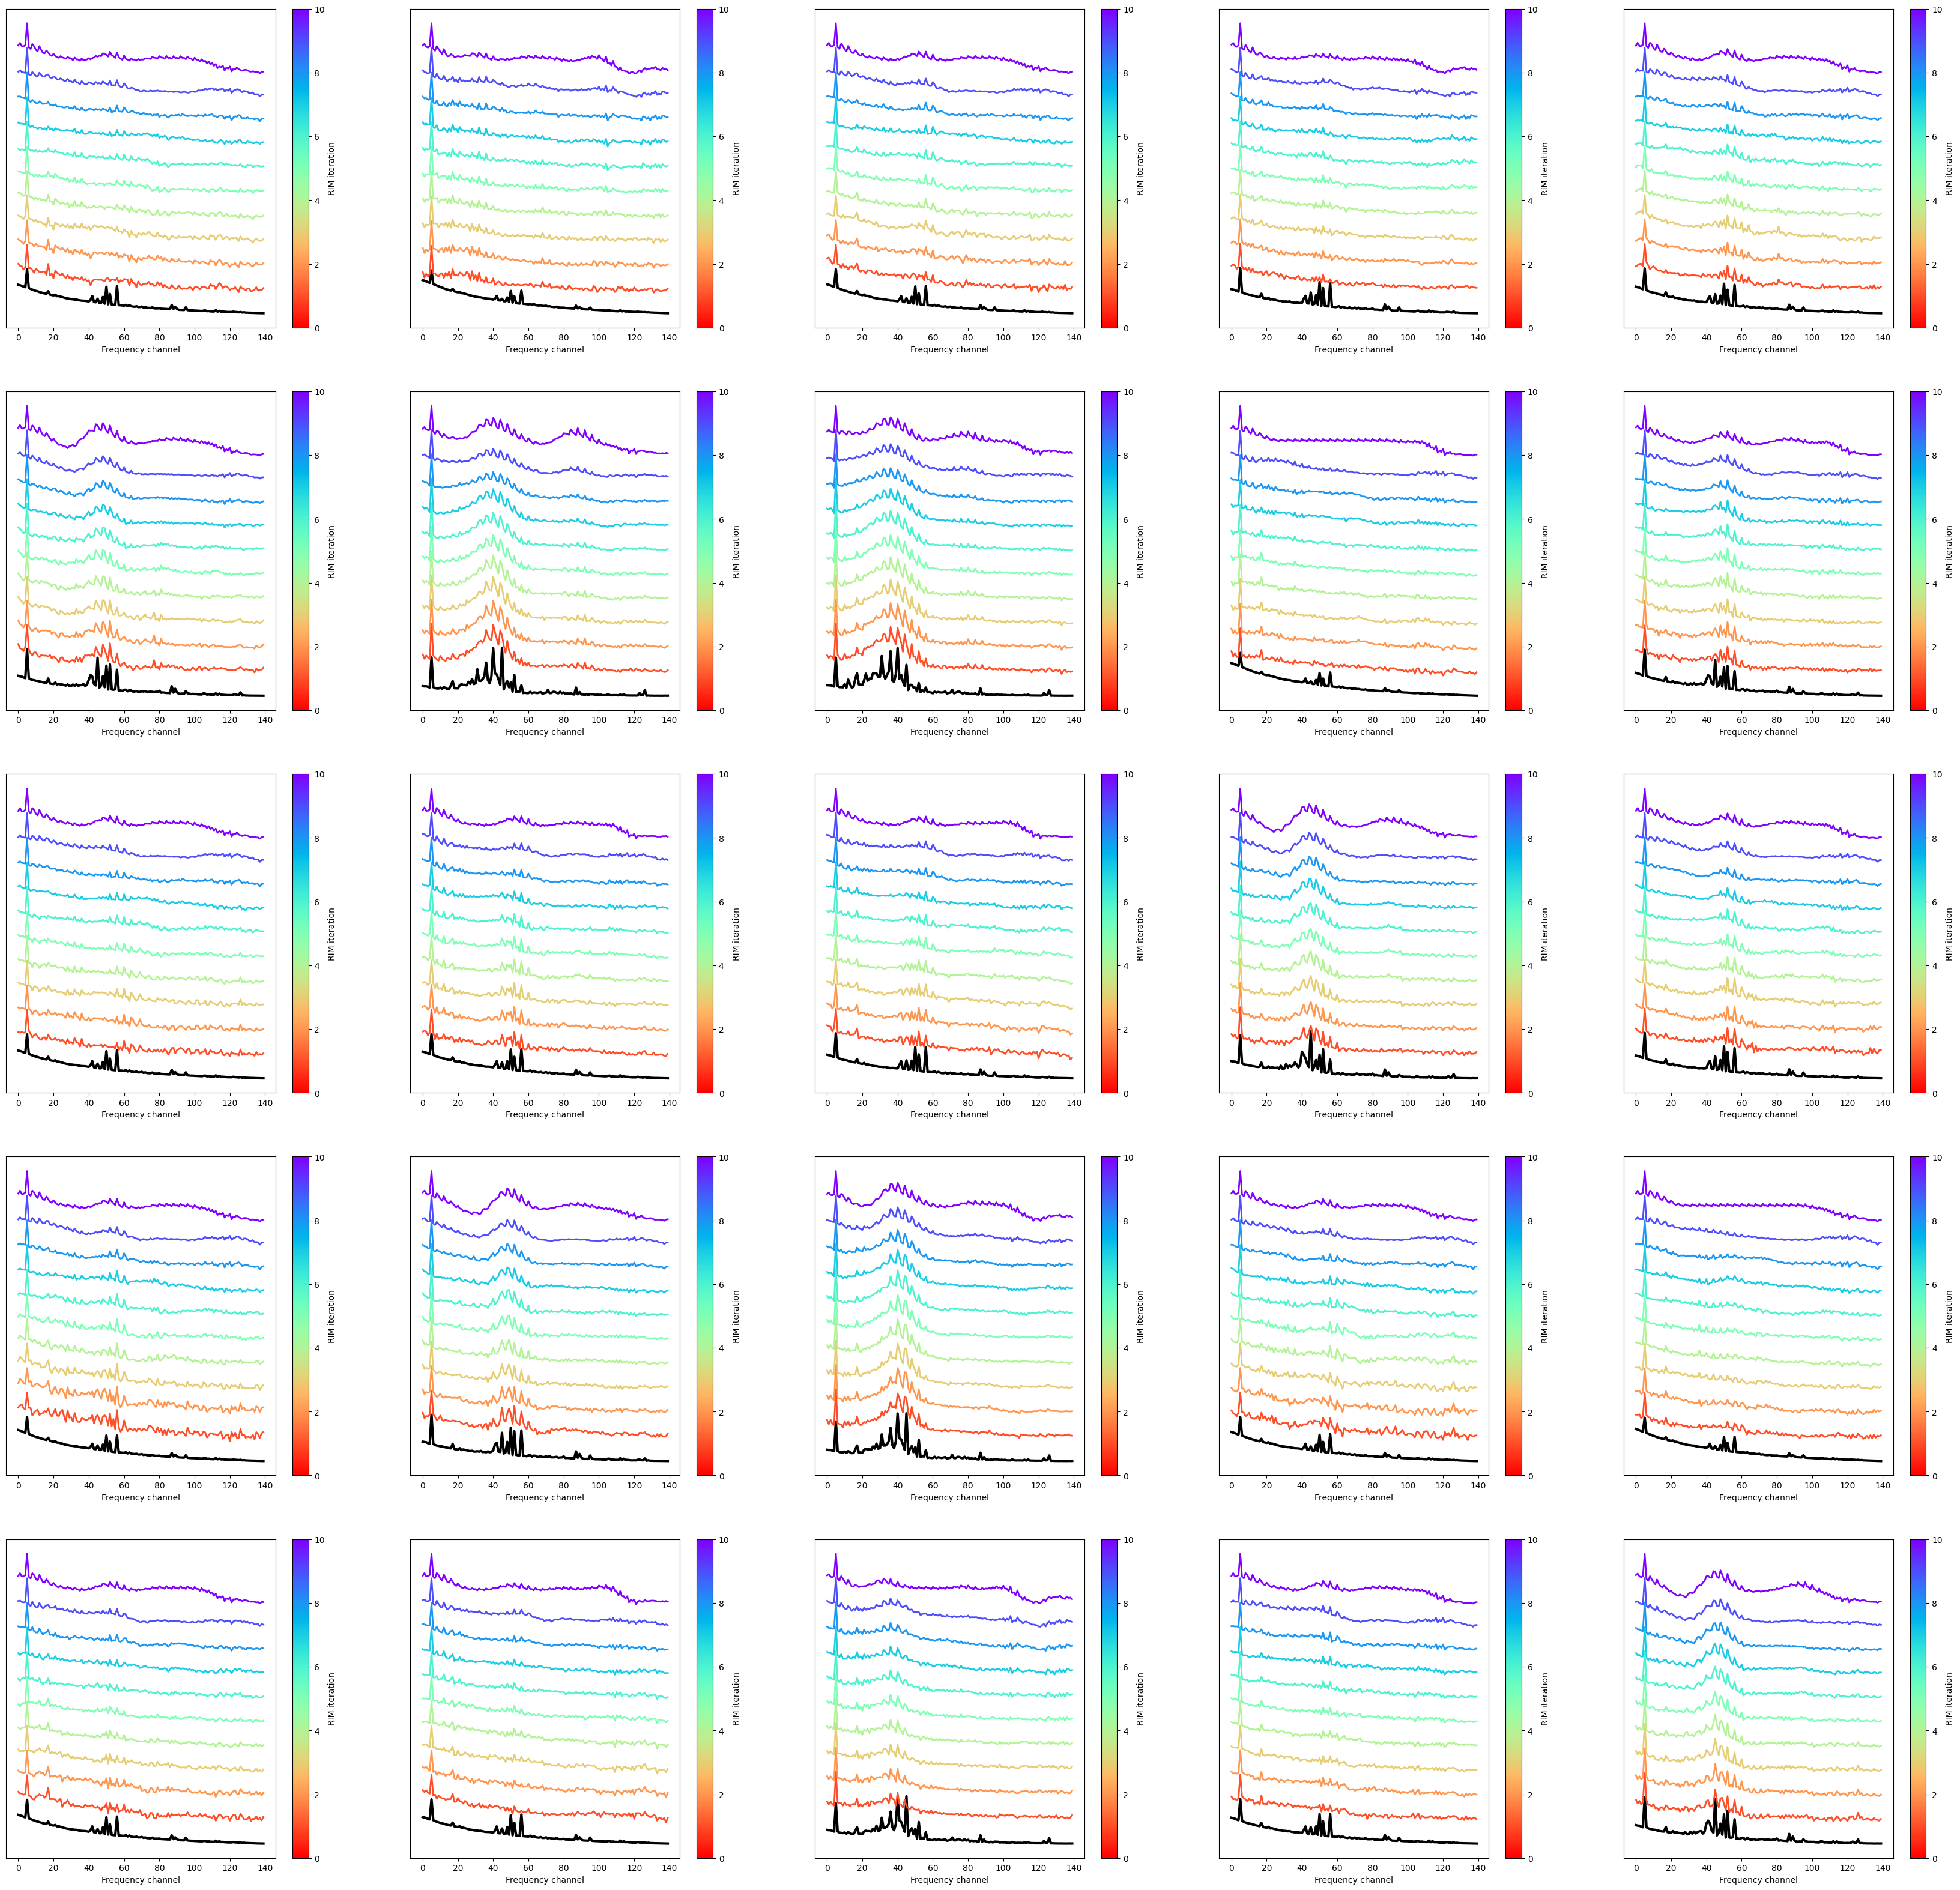

In [18]:
fig, axs = plt.subplots(5, 5, figsize=(42, 40))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
for i in range(5):
    for j in range(5):
        k = i * 5 + j
        ax = axs[i, j]
        y, x, A, sigma_n = next(iter(dataloader))
        rim.eval()
        with torch.no_grad():
            x_series = rim(y, A, sigma_n)

        cmap = plt.cm.rainbow_r
        norm = plt.cm.colors.Normalize(0, rim.T)
        ax.plot(x.squeeze().cpu()/x.cpu().max(), "-k", lw=3, label="Ground Truth")
        for t, x in enumerate(x_series):
            ax.plot(x_series[t].squeeze().cpu()/x_series[t].cpu().max() + (rim.T - t)/2, "-", color=cmap(norm(rim.T-t)), lw=2, label="RIM")
        ax.set_xlabel("Frequency channel")
        ax.get_yaxis().set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("RIM iteration")